# THOMAS MCDONNELL QTS HW 5: FX CARRY TRADE

In [161]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
import quandl
import functools
import seaborn as sns
import plotnine as p9
from plotnine import *
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
from pandas import DateOffset
import patchworklib as pw

import warnings

# Suppress the warning
warnings.filterwarnings("ignore")

In [162]:
#Overnight Swaps Data
ois = quandl.get('YC/GBR_ISSC', api_key = 'uoxc6V3s61czWuHoGLcs')
part2 = quandl.get('YC/GBR_ISSS', api_key = 'uoxc6V3s61czWuHoGLcs')
ois = pd.concat([ois, part2])
ois
gbp_yc = ois[['5.0Y']]
ois = ois[['0.08Y']]
ois/=100
gbp_yc/= 100

In [163]:
ois = ois.drop_duplicates().resample("W-WED").ffill()
idx = gbp_yc.drop_duplicates().resample("W-WED").asfreq().index
gbp_yc = gbp_yc.drop_duplicates().reindex(gbp_yc.index.union(idx)).ffill().resample("W-WED").first().dropna()
#Got help with this function for madison

In [164]:
#FX Rates Data
vnd = quandl.get("CUR/VND", authtoken="uoxc6V3s61czWuHoGLcs")
thb = quandl.get("CUR/THB", authtoken="uoxc6V3s61czWuHoGLcs")
pkr = quandl.get("CUR/PKR", authtoken="uoxc6V3s61czWuHoGLcs")
php = quandl.get("CUR/PHP", authtoken="uoxc6V3s61czWuHoGLcs")
gbp = quandl.get("CUR/GBP", authtoken="uoxc6V3s61czWuHoGLcs")

In [165]:
#Yield Curve Data
vnd_yc = quandl.get("YC/VNM", authtoken="uoxc6V3s61czWuHoGLcs")
thb_yc = quandl.get("YC/THA", authtoken="uoxc6V3s61czWuHoGLcs")
pkr_yc = quandl.get("YC/PAK", authtoken="uoxc6V3s61czWuHoGLcs")
php_yc = quandl.get("YC/PHL", authtoken="uoxc6V3s61czWuHoGLcs")

vnd_yc /= 100
thb_yc /= 100
pkr_yc /= 100
php_yc /= 100

vnd_yc = vnd_yc.resample("W-WED").ffill()
thb_yc = thb_yc.resample("W-WED").ffill()
pkr_yc = pkr_yc.resample("W-WED").ffill()
php_yc = php_yc.resample("W-WED").ffill()

vnd_yc.columns= [1,2,3,5,7,10,15]
vnd_yc = vnd_yc[[1,2,3,5]]

php_yc.columns = [.08,.25,.5,1,2,3,4,5,7,10,20,25]
php_yc = php_yc[[1,2,3,4,5]]

pkr_yc.columns = [.25,.5,1,3,5,10]
pkr_yc = pkr_yc[[1,3,5]]

thb_yc.columns = [.08,.25,.5,1,2,3,4,5,6,7,8,9,10,15]
thb_yc = thb_yc[[1.00,2.00,3.00,4.00,5.00]]

vnd_yc =vnd_yc.loc[pd.to_datetime('2014-12-03'):pd.to_datetime('2023-01-01')]
thb_yc =thb_yc.loc[pd.to_datetime('2014-12-03'):pd.to_datetime('2023-01-01')]
pkr_yc =pkr_yc.loc[pd.to_datetime('2014-12-03'):]
php_yc =php_yc.loc[pd.to_datetime('2014-12-03'):pd.to_datetime('2023-01-1')]


In [166]:
#Functions 
def spot_rate(zcb, tenor):
    times = np.arange(tenor, 0, step=-0.5)[::-1]
    if times.shape[0]==0:
        sr = None
    else:
        r = np.interp(times, zcb.index.values, zcb.values) # Linear interpolation
        coupons_pv_x = 0.5*np.exp(-r*times).sum()
        final_pv = np.exp(-tenor*r[-1])
        sr = (1.0 - final_pv) / coupons_pv_x # Solves x + c * delta = 1.0
    return sr
def compute_spot_rates(zcb_rates):
    spot = zcb_rates.copy()
    for curve in zcb_rates.columns:
        zcb = zcb_rates[curve]
        for tenor, rate in zcb.iteritems():
            if tenor>0.001:
                spot[curve][tenor] = spot_rate(zcb, tenor)
    return spot
def bond_price(zcb, coupon_rate, tenor):
    times = np.arange(tenor, 0, step=-0.25)[::-1]
    if times.shape[0]==0:
        p = 1.0
    else:
        r = np.interp(times, zcb.index.values, zcb.values) # Linear interpolation
        p = np.exp(-tenor*r[-1]) + 0.25 * coupon_rate * np.exp(-r*times).sum()
    return p
def compute_zcb_curve(spot_rates_curve):
    zcb_rates = spot_rates_curve.copy()
    for curve in spot_rates_curve.columns:
        spot = spot_rates_curve[curve]
        for tenor, spot_rate in spot.iteritems():
            if tenor>0.001:
                times = np.arange(tenor-0.25, 0, step=-0.25)[::-1]
                coupon_half_yr = 0.25*spot_rate
                z = np.interp(times, zcb_rates[curve].index.values, zcb_rates[curve].values) # Linear interpolation
                preceding_coupons_val = (coupon_half_yr*np.exp(-z*times)).sum()
                zcb_rates[curve][tenor] = -np.log((1-preceding_coupons_val)/(1+coupon_half_yr))/tenor
    return zcb_rates

In [167]:
#get zcb curves
vnd_zero_cp_bond_dict ={}
for i in range(len(vnd_yc)):
    x = vnd_yc.iloc[i].to_frame()
    x.index.name = 'Tenor'
    vnd_zero_cp_bond_dict[x.columns[0]] = compute_zcb_curve(x)

thb_zero_cp_bond_dict ={}
for i in range(len(thb_yc)):
    x = thb_yc.iloc[i].to_frame()
    x.index.name = 'Tenor'
    thb_zero_cp_bond_dict[x.columns[0]] = compute_zcb_curve(x)

php_zero_cp_bond_dict ={}
for i in range(len(php_yc)):
    x = php_yc.iloc[i].to_frame()
    x.index.name = 'Tenor'
    php_zero_cp_bond_dict[x.columns[0]] = compute_zcb_curve(x)

pkr_zero_cp_bond_dict ={}
for i in range(len(pkr_yc)):
    x = pkr_yc.iloc[i].to_frame()
    x.index.name = 'Tenor'
    pkr_zero_cp_bond_dict[x.columns[0]] = compute_zcb_curve(x)

In [168]:
#turning everything into transposed DFs

vnd_zcb_df = pd.concat(vnd_zero_cp_bond_dict, axis=1)
vnd_zcb_df.columns = vnd_zero_cp_bond_dict.keys()
vnd_zcb_df = vnd_zcb_df.T

thb_zcb_df = pd.concat(thb_zero_cp_bond_dict, axis=1)
thb_zcb_df.columns = thb_zero_cp_bond_dict.keys()
thb_zcb_df = thb_zcb_df.T

pkr_zcb_df = pd.concat(pkr_zero_cp_bond_dict, axis=1)
pkr_zcb_df.columns = pkr_zero_cp_bond_dict.keys()
pkr_zcb_df = pkr_zcb_df.T

php_zcb_df = pd.concat(php_zero_cp_bond_dict, axis=1)
php_zcb_df.columns = php_zero_cp_bond_dict.keys()
php_zcb_df = php_zcb_df.T

In [169]:
def carry_trade(currency_zcb, currency_yc, currency_fx):
    notional = 10_000_000
    leveraged_capital = 8_000_000
    trades =(currency_yc[5.0] - gbp_yc['5.0Y'] - 0.005).dropna().to_frame()
    x = pd.DataFrame(index = currency_zcb.index, columns = ['borrowed', 'returned','interest paid', 'total borrowing pnl','lending pnl', 'pnl'])
    for i in range(len(trades)-1):
        if currency_zcb.iloc[i].to_frame().columns[0].day_name() == 'Wednesday':
            if trades[0][i] > 0:
                #borrowed
                borrow_rate = (ois['0.08Y'][currency_zcb.iloc[i].to_frame().columns[0]]+0.005)/52
                borrowed_gbp = gbp.loc[currency_zcb.iloc[i].to_frame().columns[0]]['RATE']*leveraged_capital
                interest_paid = borrow_rate*borrowed_gbp/gbp.loc[currency_zcb.iloc[i+1].to_frame().columns[0]]['RATE']
                x['interest paid'][currency_zcb.iloc[i+1].to_frame().columns[0]]= interest_paid
                borrowed = 8_000_000
                returned  = borrowed * gbp['RATE'][currency_zcb.iloc[i].to_frame().columns[0]]/gbp['RATE'][currency_zcb.iloc[i+1].to_frame().columns[0]]
                x['borrowed'][currency_zcb.iloc[i+1].to_frame().columns[0]] = borrowed
                x['returned'][currency_zcb.iloc[i+1].to_frame().columns[0]] = returned
                

                #Lending
                lended_curr = notional * currency_fx.loc[currency_zcb.iloc[i].to_frame().columns[0]]['RATE']
                initial_price_of_bond = bond_price(currency_zcb.iloc[i], currency_yc.iloc[i][5], 5)
                final_price_of_bond = bond_price(currency_zcb.iloc[i+1], currency_yc.iloc[i][5], 4.9807)
                price_difference = lended_curr*final_price_of_bond - lended_curr*initial_price_of_bond
                price_difference_usd = (lended_curr + price_difference)/currency_fx.loc[currency_zcb.iloc[i+1].to_frame().columns[0]]['RATE']
                x['lending pnl'][currency_zcb.iloc[i+1].to_frame().columns[0]] = price_difference_usd-10_000_000
    x['total borrowing pnl'] = x['borrowed'] - x['returned'] - x['interest paid']
    x['pnl'] = x['total borrowing pnl'] + x['lending pnl']
    x['cumulative pnl'] = x['pnl'].cumsum()
    x = x.dropna()
    return x


In [170]:
THB_Carry = carry_trade(thb_zcb_df,thb_yc, thb)
VND_Carry = carry_trade(vnd_zcb_df,vnd_yc, vnd)
PHP_Carry = carry_trade(php_zcb_df,php_yc, php)
PKR_Carry = carry_trade(pkr_zcb_df,pkr_yc, pkr)

# 1 DATA

There were many initial data sets I had to obtain to start my FX carry backtest. First, I needed the UK overnight index swaps for 1M rates. This would be used as my borrowing rate (+50bps). I then needed yield curve data for all of my currencies with which I would be trading (VND, PHP, THB, PKR) along with the UK 5 year rate. Finally, I needed the FX rates with USD/{curr}. 

All of the yield curve data was quoted as percent (ie 4.57 insteal of .0457) so I divided all of my yield curve data by 100. I then changed all of the column names to be numbers to make the data easier to manipulate (ie 5.0 instead of "5 Years"). Since we were engaging in weekly trading, I started all of my trades on wednesdays and ended them a week later as this was easier to backtest since there are many monday holidays that aren't trading days. To deal with this, I resampled all of my data to be only wednesdays, and if a wednesday "didn't exist" as in it wasn't a trading day, I would forward fill the previous days rate. As my final piece of data cleaning, I removed all data that wasn't from December 3rd 2014 to January 1 2023 (except for PKR as their yield curve data stopped in 2020). 

The next step in obtaining data was to calculate the zero coupon bond curve via the given yield curve. Given the helper function above "compute zcb curve," I looped through all of my yield curves, imputting the 1,2 (or 3) and 5 year data to calculate my zcb curve on each date. This was needed as this was going to be one of the inputs in my bond pricing formula. Now it was time to backtest my strategy

# 2 TRADING

The goal of a carry trade is to borrow money at a smaller, short term rate, and lend money at a greater, long term rate. In an ideal carry trade, you will very frequently make small profits with the occasional big drop as you are exposed to rate changes. In an FX carry, we will lend money (go long a 5 year bond) in a foreign currency and then borrow money at the rate of OIS+50bp. WE have 5x leverage and therefore are borrowing 8 million USD worth of GBP and using 2 million of our own capital. This means that when borrowing money, we will have to pay interest but are also exposed (either positively or negatively) to the USD/GBP rate. 

To utilize my function, you input a currencies yield curve, a currencies zcb curve (calculated with the yield curve) and the currencies FX rate with USD. I then created a dataframe called trades that was the 5 year yield curve value of the foreign currency minus the GBP 5 year yield curve rate minus 50bps. This is because when this value is negative, I don't want to trade. Basically, I am only trading when the foreign currency has a 5 year rate at least 50 bps higher than the GBP 5 year rate. I then loop through all of the days in the zcb curve (every wednesday from December 2014 until the end of the data).

### Borrowing

If my foreign currencies 5 year rate is 50 bps higher than my GBP 5 year rate, I open my trades. I have both a borrowing and lending side of the carry trade. My borrow rate will be the OIS that day plus 50 bps and then divided by 52 to "un-annualize." My amount of GBP borrowed will be 8mm usd times the USD/GBP rate. My total interest paid for that trade will then be the borrowing rate multiplied by amount of GBP borrowed. To get this back in USD I must then divide by the next weeks USD/GBP rate (this doesn't have lookahead bias as I could simply simulate a week later to close my trades right before opening my trades but the values would be the same, and for backtesting purposes this is less complex). Now I have my interest payments for each week, but that isn't the only side of the borrowing PnL.

Our borrowing side is also exposed to the USD/GBP rate as we are borrowing in that currency. We are able to calculate our PnL here as 8mm multiplied by the change in FX rate and then we subtract the initial 8mm. That is

$$ 8,000,000 * \frac{r_t }{r_{t-1}} - 8,000,000 $$

or

$$ 8,000,000*( \frac{r_t }{r_{t-1}} - 1) $$

Therefore our total borrowing PnL is

$$ 8,000,000*( \frac{r_t }{r_{t-1}} - 1) - int$$

where 

$$ int =  ((OIS_t + .005)* \frac{8,000,000}{r_t}) $$


### Lending

Now on to the lending side of PnL. We first have to calculate our amount of currency lended as

$$ 10,000,000 * r_t $$

Next, we calculate the price of our 5 year bond, inputting the zero coupon bond curve at that date, the five year yield curve rate as our coupon rate and 5 years as our tenor. Then, to find the next weeks bond price we input the next wednesdays zero coupon bond curve, the same coupon rate as the week before, and 4.9807 as our tenor (1 year - 51/52). Again, this avoids lookahead bias as the value of the future bond price is unneeded for our trade, just an easy way to backtest PnL. We make money off of this change in bond price, and the amount we make (in the foreign currency) is 

$$ 10,000,000*r_t * (P_{t+1} - P_t)$$

making our final lending profit in USD to be

$$ \frac{10,000,000*r_t * (P_{t+1} - P_t)}{r_{t+1}}


Our total PNL then becomes the sum of the lending and borrowing PnL's, and I output a dataframe of all of these components seperately, including the cumulative sum of total profits. 

# 3 Analysis

I ran this FX carry trade for four different currencies, Vietnamese Dong, Thai Baht, Pakistani Rupee and Philippine Peso. Below are the outputs of total cumulative PnL, the USD/{curr} rate, the foreign currencies 5 year yield curve rate and the OIS + 50bps.

### Performance

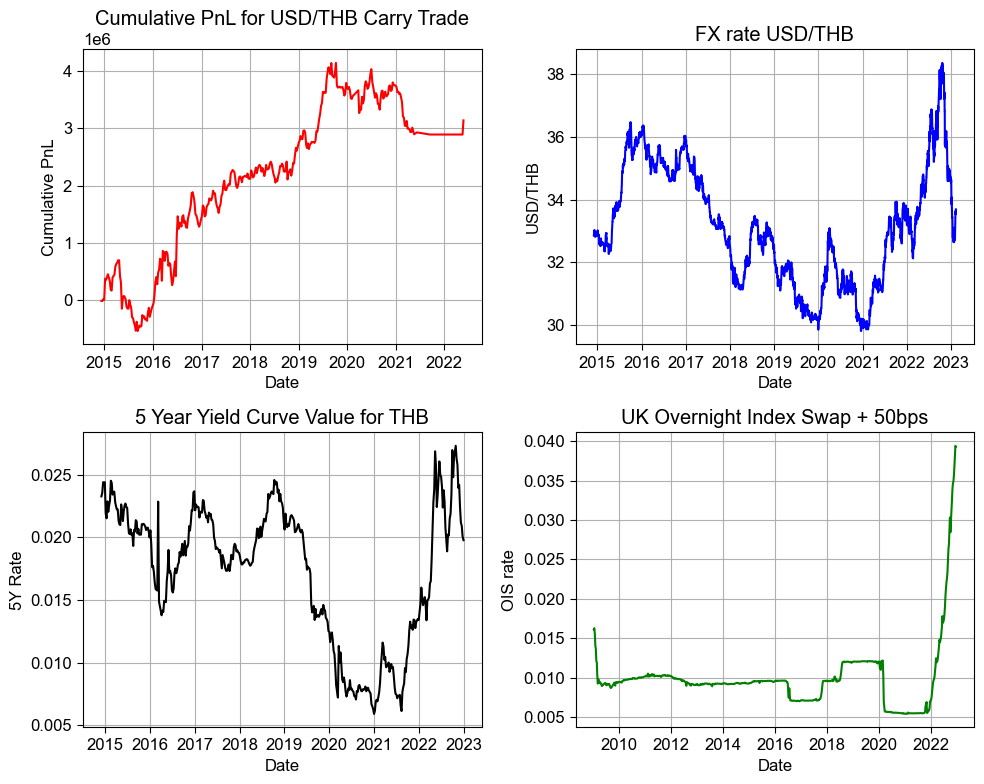

In [171]:
# Set the figure and subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Plot cumulative PnL
axs[0,0].plot(THB_Carry.index, THB_Carry['cumulative pnl'], color='red', label='Cumulative PnL')
axs[0,0].set_title("Cumulative PnL for USD/THB Carry Trade")
axs[0,0].set_xlabel("Date")
axs[0,0].set_ylabel("Cumulative PnL")
axs[0,0].grid(True)

# Plot RATE
axs[0,1].plot(thb.loc[pd.to_datetime('2014-12-03'):].index, thb.loc[pd.to_datetime('2014-12-03'):]['RATE'], color='blue', label='RATE')
axs[0,1].set_title("FX rate USD/THB")
axs[0,1].set_xlabel("Date")
axs[0,1].set_ylabel("USD/THB")
axs[0,1].grid(True)


axs[1,0].plot(thb_yc[5.0], color='black', label='RATE')
axs[1,0].set_title("5 Year Yield Curve Value for THB")
axs[1,0].set_xlabel("Date")
axs[1,0].set_ylabel("5Y Rate")
axs[1,0].grid(True)

axs[1,1].plot(ois+0.005, color='green', label='RATE')
axs[1,1].set_title("UK Overnight Index Swap + 50bps")
axs[1,1].set_xlabel("Date")
axs[1,1].set_ylabel("OIS rate")
axs[1,1].grid(True)

plt.tight_layout()
plt.show()

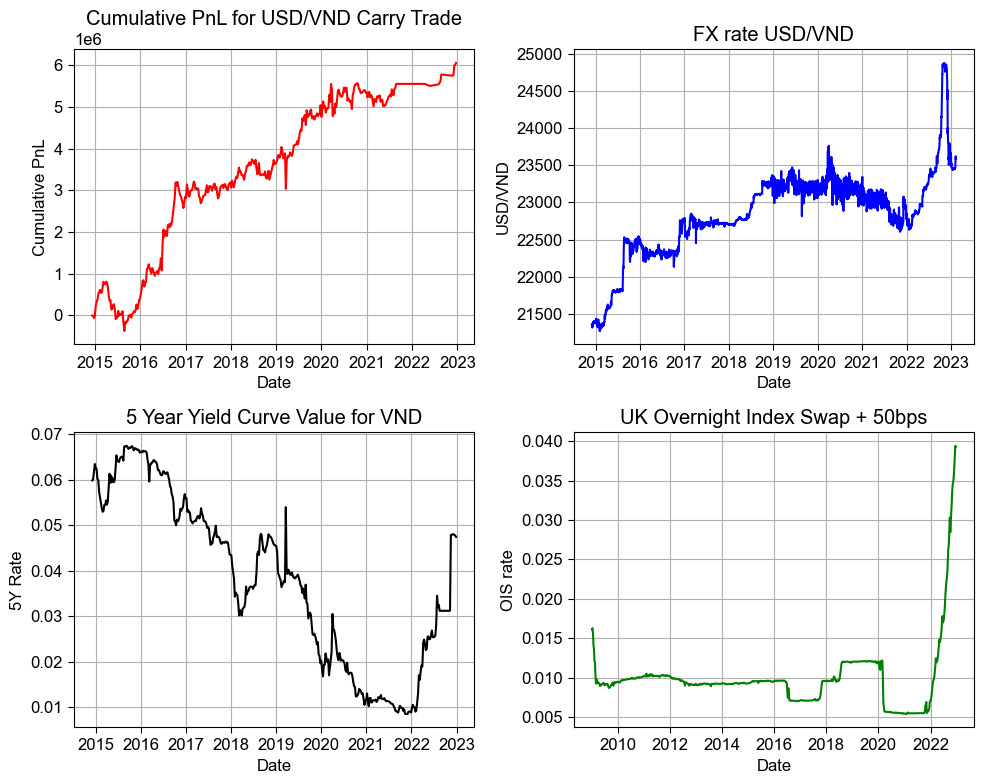

In [172]:
# Set the figure and subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Plot cumulative PnL
axs[0,0].plot(VND_Carry.index, VND_Carry['cumulative pnl'], color='red', label='Cumulative PnL')
axs[0,0].set_title("Cumulative PnL for USD/VND Carry Trade")
axs[0,0].set_xlabel("Date")
axs[0,0].set_ylabel("Cumulative PnL")
axs[0,0].grid(True)

# Plot RATE
axs[0,1].plot(vnd.loc[pd.to_datetime('2014-12-03'):].index, vnd.loc[pd.to_datetime('2014-12-03'):]['RATE'], color='blue', label='RATE')
axs[0,1].set_title("FX rate USD/VND")
axs[0,1].set_xlabel("Date")
axs[0,1].set_ylabel("USD/VND")
axs[0,1].grid(True)

axs[1,0].plot(vnd_yc[5.0], color='black', label='RATE')
axs[1,0].set_title("5 Year Yield Curve Value for VND")
axs[1,0].set_xlabel("Date")
axs[1,0].set_ylabel("5Y Rate")
axs[1,0].grid(True)

axs[1,1].plot(ois+0.005, color='green', label='RATE')
axs[1,1].set_title("UK Overnight Index Swap + 50bps")
axs[1,1].set_xlabel("Date")
axs[1,1].set_ylabel("OIS rate")
axs[1,1].grid(True)


plt.tight_layout()
plt.show()

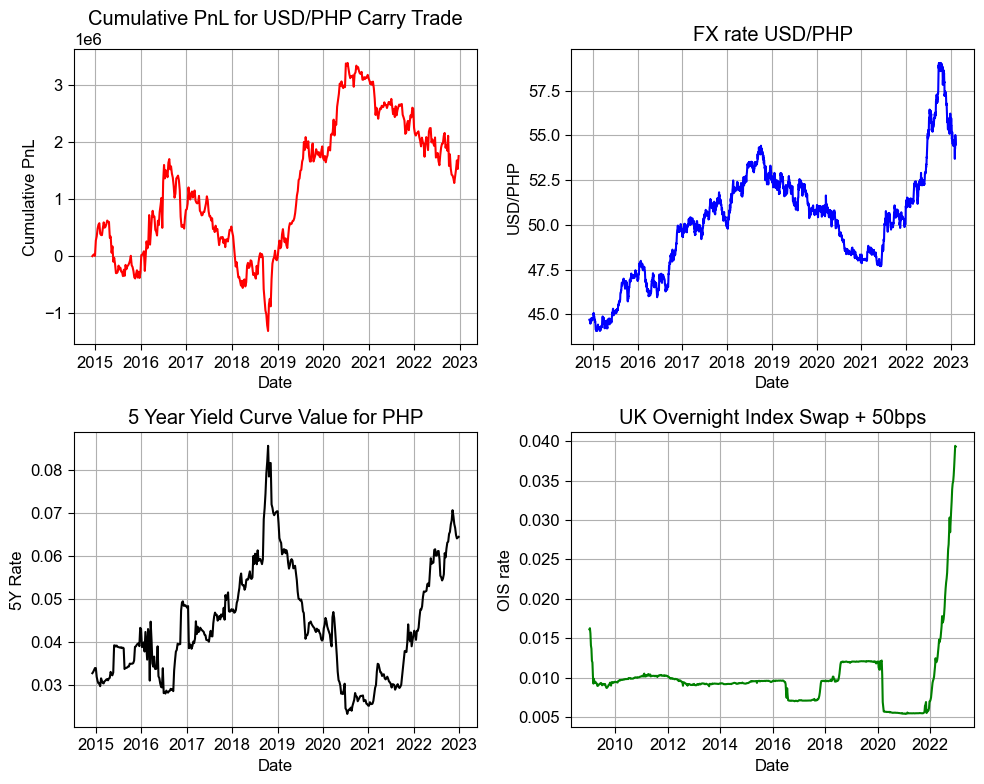

In [173]:
# Set the figure and subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Plot cumulative PnL
axs[0,0].plot(PHP_Carry.index, PHP_Carry['cumulative pnl'], color='red', label='Cumulative PnL')
axs[0,0].set_title("Cumulative PnL for USD/PHP Carry Trade")
axs[0,0].set_xlabel("Date")
axs[0,0].set_ylabel("Cumulative PnL")
axs[0,0].grid(True)

# Plot RATE
axs[0,1].plot(php.loc[pd.to_datetime('2014-12-03'):].index, php.loc[pd.to_datetime('2014-12-03'):]['RATE'], color='blue', label='RATE')
axs[0,1].set_title("FX rate USD/PHP")
axs[0,1].set_xlabel("Date")
axs[0,1].set_ylabel("USD/PHP")
axs[0,1].grid(True)\

axs[1,0].plot(php_yc[5.0], color='black', label='RATE')
axs[1,0].set_title("5 Year Yield Curve Value for PHP")
axs[1,0].set_xlabel("Date")
axs[1,0].set_ylabel("5Y Rate")
axs[1,0].grid(True)

axs[1,1].plot(ois+0.005, color='green', label='RATE')
axs[1,1].set_title("UK Overnight Index Swap + 50bps")
axs[1,1].set_xlabel("Date")
axs[1,1].set_ylabel("OIS rate")
axs[1,1].grid(True)



plt.tight_layout()
plt.show()

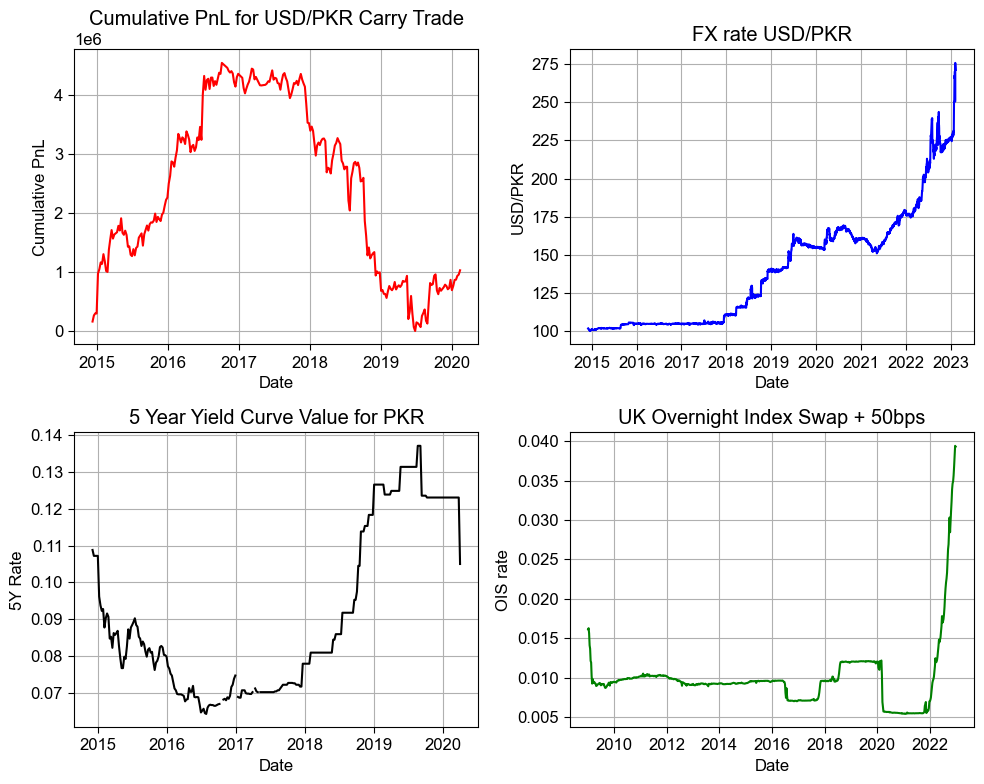

In [174]:
# Set the figure and subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Plot cumulative PnL
axs[0,0].plot(PKR_Carry.index, PKR_Carry['cumulative pnl'], color='red', label='Cumulative PnL')
axs[0,0].set_title("Cumulative PnL for USD/PKR Carry Trade")
axs[0,0].set_xlabel("Date")
axs[0,0].set_ylabel("Cumulative PnL")
axs[0,0].grid(True)

# Plot RATE
axs[0,1].plot(pkr.loc[pd.to_datetime('2014-12-03'):].index, pkr.loc[pd.to_datetime('2014-12-03'):]['RATE'], color='blue', label='RATE')
axs[0,1].set_title("FX rate USD/PKR")
axs[0,1].set_xlabel("Date")
axs[0,1].set_ylabel("USD/PKR")
axs[0,1].grid(True)

axs[1,0].plot(pkr_yc[5.0], color='black', label='RATE')
axs[1,0].set_title("5 Year Yield Curve Value for PKR")
axs[1,0].set_xlabel("Date")
axs[1,0].set_ylabel("5Y Rate")
axs[1,0].grid(True)

axs[1,1].plot(ois+0.005, color='green', label='RATE')
axs[1,1].set_title("UK Overnight Index Swap + 50bps")
axs[1,1].set_xlabel("Date")
axs[1,1].set_ylabel("OIS rate")
axs[1,1].grid(True)


plt.tight_layout()
plt.show()

As you can see from the graphs above, all of my FX carry trades made profit over this time period, ranging from one million dollars for Pakistan to 6 million dollars for vietnam. In Pakistan during this time period, the strenght of one PKR greatly decreased tue to termoil in the country and economy and the USD/PKR rate jumped from 100 to 275 over this period. Since we were lending money in PKR and then transferring back to USD we were losing money more frequently as this rate started to rise quicker (2018).

It is also noticable simply from the graphs the total PNL seems to have a somewhat inverse relationship with the 5 year yield curve values, and that will be something I explore below in the correlation section.

Below is a graph of the USD/GBP rate during this time period as well.

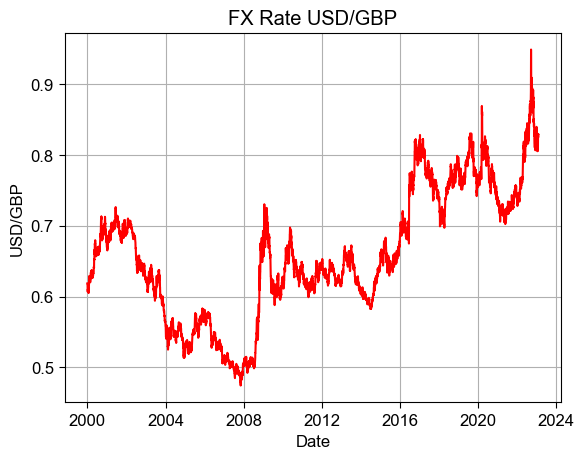

In [175]:
# Plot cumulative PnL
plt.plot(gbp.index, gbp['RATE'], color='red', label='Cumulative PnL')
plt.title("FX Rate USD/GBP")
plt.xlabel("Date")
plt.ylabel("USD/GBP")
plt.grid(True)
plt.show()

### Correlation

Below are the correlations of total cumulative profits with the 5 year rates of the yield curve for each currency.

In [176]:
thb_yc_filter = thb_yc[[5]].reindex(THB_Carry.index)
pkr_yc_filter = pkr_yc[[5]].reindex(PKR_Carry.index)
vnd_yc_filter = vnd_yc[[5]].reindex(VND_Carry.index)
php_yc_filter = php_yc[[5]].reindex(PHP_Carry.index)
THB_Carry = THB_Carry.merge(thb_yc_filter, on = THB_Carry.index)
PKR_Carry = PKR_Carry.merge(pkr_yc_filter, on = PKR_Carry.index)
VND_Carry = VND_Carry.merge(vnd_yc_filter, on = VND_Carry.index)
PHP_Carry = PHP_Carry.merge(php_yc_filter, on = PHP_Carry.index)

THB_Carry['cumulative pnl'] = THB_Carry['cumulative pnl'].astype(float)
THB_Carry[5.0] = THB_Carry[5.0].astype(float)
PKR_Carry['cumulative pnl'] = PKR_Carry['cumulative pnl'].astype(float)
PKR_Carry[5.0] = PKR_Carry[5.0].astype(float)
VND_Carry['cumulative pnl'] = VND_Carry['cumulative pnl'].astype(float)
VND_Carry[5.0] = VND_Carry[5.0].astype(float)
PHP_Carry['cumulative pnl'] = PHP_Carry['cumulative pnl'].astype(float)
PHP_Carry[5.0] = PHP_Carry[5.0].astype(float)

correlation = pd.DataFrame(index = ['THB', 'PKR', 'VND', 'PHP'], columns = ['correlation with 5 year YC'])
correlation.iloc[0]['correlation with 5 year YC'] = THB_Carry['cumulative pnl'].corr(THB_Carry[5.0])
correlation.iloc[1]['correlation with 5 year YC'] = PKR_Carry['cumulative pnl'].corr(PKR_Carry[5.0])
correlation.iloc[2]['correlation with 5 year YC'] = VND_Carry['cumulative pnl'].corr(VND_Carry[5.0])
correlation.iloc[3]['correlation with 5 year YC'] = PHP_Carry['cumulative pnl'].corr(PHP_Carry[5.0])
correlation

,correlation with 5 year YC
THB,-0.627598
PKR,-0.875935
VND,-0.90016
PHP,-0.480817


It is very noticable that profits are somewhat strongly negatively correlated with the five year yield curve rates. This makes complete economic sense because as these rates are falling, the prices of bonds are increasing. This means that if you buy a 5 year bond one week and sell it the next week, not only are you making money from accrued interest, you are also making money because the price of the bond is increasing due to lower rates. 

### Tail Risk

In [178]:
def tailMetrics(returns, quantile=.05, relative=False, mdd=True):
    metrics = pd.DataFrame(index=returns.columns)
    metrics['Skewness'] = returns.skew()
    metrics['Kurtosis'] = returns.kurtosis()

    VaR = returns.quantile(quantile)
    CVaR = (returns[returns < returns.quantile(quantile)]).mean()

    if relative:
        VaR = (VaR - returns.mean())/returns.std()
        CVaR = (CVaR - returns.mean())/returns.std()

    metrics[f'VaR ({quantile})'] = VaR
    metrics[f'CVaR ({quantile})'] = CVaR


    return metrics

In [194]:
THB_Carry['pnl'] = THB_Carry['pnl'].astype(float)
PKR_Carry['pnl'] = PKR_Carry['pnl'].astype(float)
PHP_Carry['pnl'] = PHP_Carry['pnl'].astype(float)
VND_Carry['pnl'] = VND_Carry['pnl'].astype(float)
x = tailMetrics(THB_Carry[['pnl']])
y = tailMetrics(PKR_Carry[['pnl']])
z = tailMetrics(VND_Carry[['pnl']])
n = tailMetrics(PHP_Carry[['pnl']])
tail_risk = pd.concat([x,y,z,n])
tail_risk.index = ['THB', 'PKR', 'VND', 'PHP']
tail_risk

,Skewness,Kurtosis,VaR (0.05),CVaR (0.05)
THB,0.406438,5.112098,-162213.186976,-265829.057562
PKR,-0.284620,5.588653,-245473.887608,-398253.315513
VND,-0.342965,7.756322,-172611.944269,-282464.550218
PHP,0.115690,3.186631,-232520.784708,-336721.765709


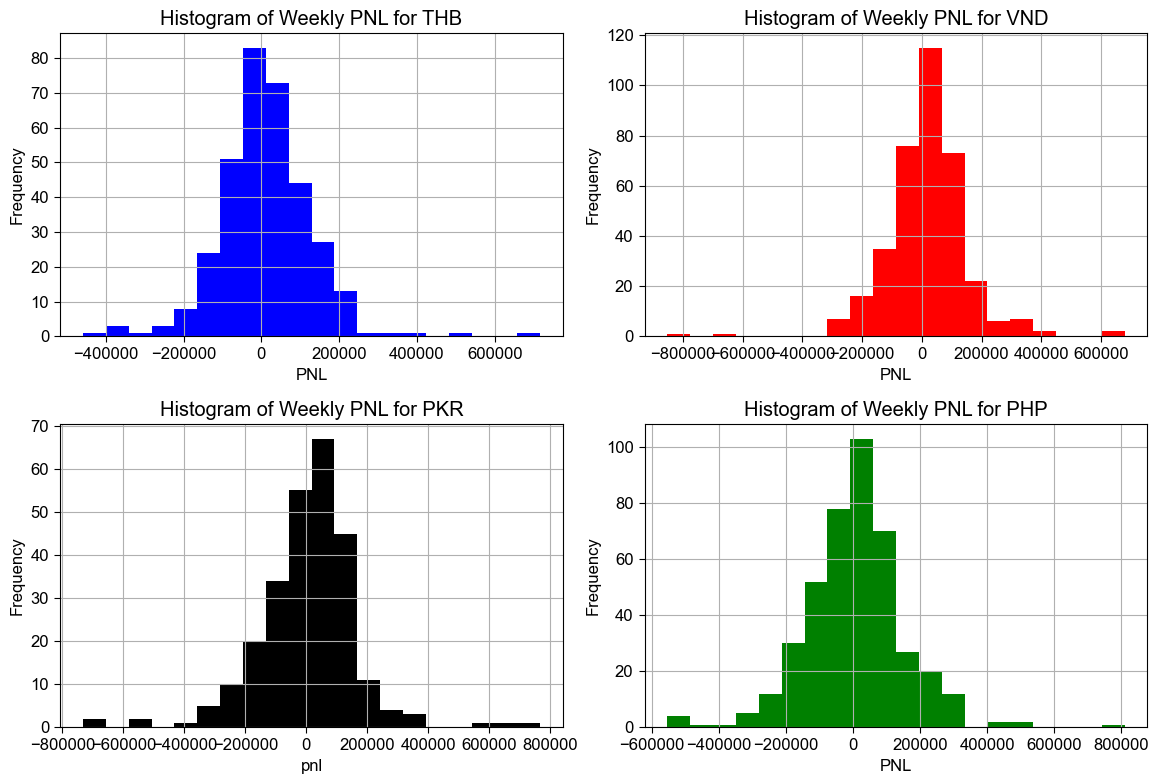

In [216]:
# Set the figure and subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Plot cumulative PnL
axs[0,0].hist(THB_Carry['pnl'], bins=20, color='blue')
axs[0,0].set_title("Histogram of Weekly PNL for THB")
axs[0,0].set_xlabel("PNL")
axs[0,0].set_ylabel("Frequency")
axs[0,0].grid(True)

# Plot RATE
axs[0,1].hist(VND_Carry['pnl'], bins=20, color='red')
axs[0,1].set_title("Histogram of Weekly PNL for VND")
axs[0,1].set_xlabel("PNL")
axs[0,1].set_ylabel("Frequency")
axs[0,1].grid(True)

axs[1,0].hist(PKR_Carry['pnl'], bins=20, color='black')
axs[1,0].set_title("Histogram of Weekly PNL for PKR")
axs[1,0].set_xlabel("pnl")
axs[1,0].set_ylabel("Frequency")
axs[1,0].grid(True)

axs[1,1].hist(PHP_Carry['pnl'], bins=20, color='green')
axs[1,1].set_title("Histogram of Weekly PNL for PHP")
axs[1,1].set_xlabel("PNL")
axs[1,1].set_ylabel("Frequency")
axs[1,1].grid(True)


plt.tight_layout()
plt.show()

One of the main statistical traits of carry trades is that it has more frequent positive PNL values than negative values. As seen form these plots, the most common pnl for VND, PKR and PHP is slightly above zero. This makes sense as we normally observe frequent small gains and rare large losses in a FX carry trade. This will result in a negative skew as well. One of the economic reasons for why I believe that our VND trade doesn't seem to show this and has slightly positive skew is due to the fact that the VND yield curve 5 year rate was pretty much constantly decreasing during our time period. Also, while the USD/VND rate grew (VND value decreasing), this percent gain was much smaller than for many of the other FX rates, and the losses due to FX rate change were likely outweighed by the larger bond price spread from week to week. 

Another statistical trait of FX carry trade PnL data is that it should have high Kurtosis. All of my daily PNL returns have very high kurtosis as they have a very skinny center when a large portion of the values very close to eachother in the center. This is also due to the fact the FX carry trades are supposed to generate small steady profit, so the majority of our weekly PNL's were within a very small distance of eachother. 